# Import

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#If using NeuralNetworks
import torch
from torch import nn
from utils import *
import schedulefree

In [4]:
df = pd.read_csv('Data/OpenHSR.csv')
df = pd.get_dummies(df, columns = ['category'])

# HSR calculator

In [5]:
X = df[df.select_dtypes(include=['float64', 'int64', 'bool']).columns].drop(columns=['HSR'])
y = df['HSR']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
def transformation_HSR_predictions(predictions):
    ind_min = predictions < 0.5
    ind_max = predictions > 5.0
    predictions[ind_min] = 0.5
    predictions[ind_max] = 5.0
    return predictions

In [7]:
loss_dict = {}
acc_dict = {}
acc_by_one_dict = {}

## LinearRegression

In [ ]:
LR = sklearn.linear_model.LinearRegression()
LR = LR.fit(X_train, y_train)

In [10]:
HSR_pred_LR = transformation_HSR_predictions(LR.predict(X_test))
error_pred_LR = np.round(((HSR_pred_LR - y_test)**2).mean(),3)
loss_dict['LR'] = error_pred_LR
print(error_pred_LR)
star_pred_LR = np.round(HSR_pred_LR * 2) / 2
acc_LR = np.abs(star_pred_LR - y_test) == 0
acc_by_one_LR = np.abs(star_pred_LR - y_test) <= 0.5
acc_dict['LR'] = acc_LR.mean()
acc_by_one_dict['LR'] = acc_by_one_LR.mean()
print(acc_LR.mean(), acc_by_one_LR.mean())

0.816
0.42 0.76


## DecisionTreeRegression

In [11]:
DTR = sklearn.tree.DecisionTreeRegressor(random_state=0, max_depth=4, min_samples_split = 10, max_features = 8)
DTR = DTR.fit(X_train, y_train)

In [12]:
HSR_pred_DTR = transformation_HSR_predictions(DTR.predict(X_test))
error_pred_DTR = np.round(((HSR_pred_DTR - y_test)**2).mean(),3)
loss_dict['DTR'] = error_pred_DTR
print(error_pred_DTR)
star_pred_DTR = np.round(HSR_pred_DTR * 2) / 2
acc_DTR = np.abs(star_pred_DTR - y_test) == 0
acc_by_one_DTR = np.abs(star_pred_DTR - y_test) <= 0.5
acc_dict['DTR'] = acc_DTR.mean()
acc_by_one_dict['DTR'] = acc_by_one_DTR.mean()
print(acc_DTR.mean(), acc_by_one_DTR.mean())

0.549
0.34 0.76


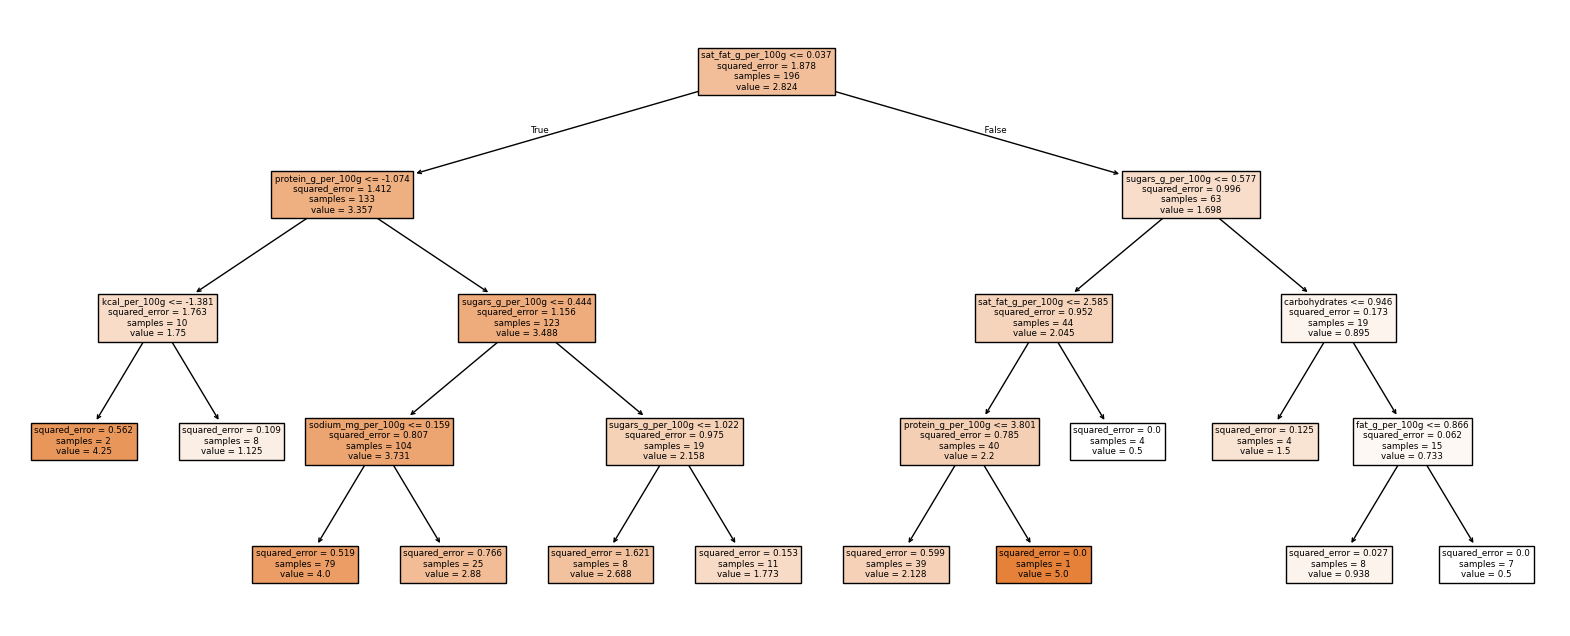

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
sklearn.tree.plot_tree(DTR, feature_names=X.columns, filled=True, ax=ax)
plt.show()

## RandomForestRegression

In [14]:
RFR = sklearn.ensemble.RandomForestRegressor(max_depth=5, min_samples_split = 5, max_features = 'log2', random_state=0)
RFR.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
HSR_pred_RFR = transformation_HSR_predictions(RFR.predict(X_test))
error_pred_RFR = np.round(((HSR_pred_RFR - y_test)**2).mean(),3)
loss_dict['RFR'] = error_pred_RFR
print(error_pred_RFR)
star_pred_RFR = np.round(HSR_pred_RFR * 2) / 2
acc_RFR = np.abs(star_pred_RFR - y_test) == 0
acc_by_one_RFR = np.abs(star_pred_RFR - y_test) <= 0.5
acc_dict['RFR'] = acc_RFR.mean()
acc_by_one_dict['RFR'] = acc_by_one_RFR.mean()
print(acc_RFR.mean(), acc_by_one_RFR.mean())

0.39
0.32 0.84


## KNeighborsRegression

In [16]:
KNR = sklearn.neighbors.KNeighborsRegressor()
parameters = {'n_neighbors':[3, 5, 7, 10, 20]}
KNR_gs = sklearn.model_selection.GridSearchCV(KNR, parameters)
KNR_gs.fit(X_train, y_train)
df_grid_search_result_KNR = pd.DataFrame(KNR_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)  
best_params_KNR = df_grid_search_result_KNR.iloc[0].params
print(best_params_KNR)
k = best_params_KNR['n_neighbors']
KNR = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k)
KNR = KNR.fit(X_train, y_train)

{'n_neighbors': 7}


In [17]:
HSR_pred_KNR = transformation_HSR_predictions(KNR.predict(X_test))
error_pred_KNR = np.round(((HSR_pred_KNR - y_test)**2).mean(),3)
loss_dict['KNR'] = error_pred_KNR
print(error_pred_KNR)
star_pred_KNR = np.round(HSR_pred_KNR * 2) / 2
acc_KNR = np.abs(star_pred_KNR - y_test) == 0
acc_by_one_KNR = np.abs(star_pred_KNR - y_test) <= 0.5
acc_dict['KNR'] = acc_KNR.mean()
acc_by_one_dict['KNR'] = acc_by_one_KNR.mean()
print(acc_KNR.mean(), acc_by_one_KNR.mean())

0.493
0.38 0.84


## XGBoostRegression

In [19]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [20]:
XGBR = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.ensemble.GradientBoostingRegressor(**params)) 
XGBR.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('gradientboostingregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,learning_rate,0.01
,n_estimators,500
,subsample,1.0


In [21]:
HSR_pred_XGBR = transformation_HSR_predictions(XGBR.predict(X_test))
error_pred_XGBR = np.round(((HSR_pred_XGBR - y_test)**2).mean(),3)
loss_dict['XGBR'] = error_pred_XGBR
print(error_pred_XGBR)
star_pred_XGBR = np.round(HSR_pred_XGBR * 2) / 2
acc_XGBR = np.abs(star_pred_XGBR - y_test) == 0
acc_by_one_XGBR = np.abs(star_pred_XGBR - y_test) <= 0.5
acc_dict['XGBR'] = acc_XGBR.mean()
acc_by_one_dict['XGBR'] = acc_by_one_XGBR.mean()
print(acc_XGBR.mean(), acc_by_one_XGBR.mean())

0.354
0.54 0.92


## SuportVectorMachine Regression

In [ ]:
parameters = {'kernel':['rbf', 'poly'], 'C':[10**2, 10**3, 10**4], 'epsilon': [ 0.01, 0.1, 0.5]}
SVR_pipeline = sklearn.svm.SVR()
SVR_gs = sklearn.model_selection.GridSearchCV(SVR_pipeline, parameters)
SVR_gs.fit(X_train, y_train)

,estimator,SVR()
,param_grid,"{'C': [10000, 100000, ...], 'epsilon': [0.001, 0.01, ...], 'kernel': ['rbf', 'poly']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [232]:
df_grid_search_result = pd.DataFrame(SVR_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)  
best_params = df_grid_search_result.iloc[0].params
print(best_params)
C = best_params['C']
epsilon = best_params['epsilon']
kernel = best_params['kernel']
SVR = sklearn.svm.SVR(C=C, epsilon=epsilon, kernel=kernel)
SVR = SVR.fit(X_train, y_train)

{'C': 10000, 'epsilon': 1, 'kernel': 'rbf'}


In [233]:
HSR_predictions = transformation_HSR_predictions(SVR.predict(X_test))
((HSR_predictions - y_test)**2).mean()

np.float64(0.8085923571733648)

In [25]:
SVR = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVR(C=10**5, epsilon=1, kernel= 'rbf'))
SVR = SVR.fit(X_train, y_train)

In [74]:
SVR = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVR(C=100, epsilon=0.01, kernel= 'rbf'))
SVR = SVR.fit(X_train, y_train)

In [75]:
HSR_pred_SVR = transformation_HSR_predictions(SVR.predict(X_test))
error_pred_SVR = np.round(((HSR_pred_SVR - y_test)**2).mean(),3)
loss_dict['SVR'] = error_pred_SVR
print(error_pred_SVR)
star_pred_SVR = np.round(HSR_pred_SVR * 2) / 2
acc_SVR = np.abs(star_pred_SVR - y_test) == 0
acc_by_one_SVR = np.abs(star_pred_SVR - y_test) <= 0.5
acc_dict['SVR'] = acc_SVR.mean()
acc_by_one_dict['SVR'] = acc_by_one_SVR.mean()
print(acc_SVR.mean(), acc_by_one_SVR.mean())

0.275
0.62 0.86


## Neural Network

In [24]:
seed = 123
indexs = np.arange(len(X_train))
np.random.seed(seed)
np.random.shuffle(indexs)
train_size = int(0.8 * len(X_train))
X_train_2, y_train_2  = X_train[indexs[:train_size]], y_train.values[indexs[:train_size]]
X_valid, y_valid      = X_train[indexs[train_size:]], y_train.values[indexs[train_size:]]

In [25]:
X_train_tensor, y_train_tensor = torch.from_numpy(X_train_2.astype(np.float32)), torch.from_numpy(y_train_2.astype(np.float32))
X_valid_tensor, y_valid_tensor = torch.from_numpy(X_valid.astype(np.float32)), torch.from_numpy(y_valid.astype(np.float32))
X_test_tensor, y_test_tensor   = torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.values.astype(np.float32))

In [ ]:
result_path = './NN/'
batch_size = 32

model = Network(X_train_tensor.shape[1], 
                activation_bool = False, 
                n_nodes = 32, 
                n_loop  = 3)

optimizer = schedulefree.AdamWScheduleFree(model.parameters(), 
                                           lr=0.01) #torch.optim.AdamW(model.parameters(), lr = 0.001)
net_path = result_path + 'net_state_dic.pt'

'''
list_loss_train, list_loss_valid = training_network_threshold(model, 
                           optimizer,
                           X_train    = X_train_tensor,
                           Y_train    = y_train_tensor,
                           X_test     = X_valid_tensor,
                           Y_test     = y_valid_tensor,
                           epochs     = 7,
                           batch_size = batch_size,
                           )

torch.save(model.state_dict(), net_path)
'''
model.load_state_dict(torch.load(net_path, weights_only=True))
model.eval()


'\nmodel.load_state_dict(torch.load(net_path, weights_only=True))\nmodel.eval()\n'

In [176]:
list_loss_train.mean(axis = 1)[-3:], list_loss_valid.mean(axis = 1)[-3:]

(array([0.42628529, 0.32034075, 0.23415757]),
 array([0.86043423, 0.79715085, 0.74006003]))

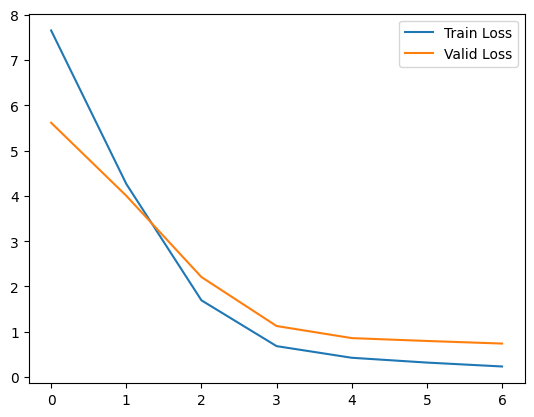

In [177]:
plt.plot(list_loss_train.mean(axis = 1), label='Train Loss')
plt.plot(list_loss_valid.mean(axis = 1), label='Valid Loss')
plt.legend()
plt.show()

In [178]:
model.eval()
train_loss = ((transformation_HSR_predictions(model(X_train_tensor).squeeze()) - y_train_tensor)**2).mean()
valid_loss = ((transformation_HSR_predictions(model(X_valid_tensor).squeeze()) - y_valid_tensor)**2).mean()
test_loss  = ((transformation_HSR_predictions(model(X_test_tensor).squeeze()) - y_test_tensor)**2).mean()
print(train_loss.item(), valid_loss.item(), test_loss.item())

0.3388122022151947 0.7570196390151978 0.6666979789733887


In [182]:
HSR_pred_NN = transformation_HSR_predictions(model(X_test_tensor).squeeze()).detach().numpy()
error_pred_NN = np.round(((HSR_pred_NN - y_test)**2).mean(),3)
loss_dict['NN'] = error_pred_NN
print(error_pred_NN)
star_pred_NN = np.round(HSR_pred_NN * 2) / 2
acc_NN = np.abs(star_pred_NN - y_test) == 0
acc_by_one_NN = np.abs(star_pred_NN - y_test) <= 0.5
acc_dict['NN'] = acc_NN.mean()
acc_by_one_dict['NN'] = acc_by_one_NN.mean()
print(acc_NN.mean(), acc_by_one_NN.mean())

0.667
0.4 0.78


## NN fine-tuning

### Dataset Prepro

In [8]:
df_openfoodfacts = pd.read_csv('Data/en.openfoodfacts.org.products.tsv', sep='\t',  low_memory=False)

In [ ]:
"""
for col_name in df_openfoodfacts.columns:
    print(col_name)
print(df_openfoodfacts.categories.value_counts()[df_openfoodfacts.categories.value_counts() > 25].to_latex())
"""

In [9]:
dic_cat_off_to_cat_hsr = {
    'en:beverages' : '1',
    'en:non-sugared-beverages, en:beverages' : '1',
    'en:sugared-beverages, en:beverages' : '1',
    'Squeezed-apple-juices' : '1',
    'Boissons aux fruits' : '1',
    'Ketchup' : '3',
    'Snacks sucrés,Biscuits et gâteaux,Biscuits' : '2',
    'Snacks sucrés,Chocolats,Chocolats noirs' : '2',
    'Snacks sucrés,Chocolats,Chocolats au lait' : '2',
    'Snacks sucrés,Chocolats,Chocolats blancs' : '2',
    'Viandes,Charcuteries,Jambons,Jambons blancs' : '2',
    'Snacks sucrés,Confiseries,Bonbons' : '2',
    'Snacks salés,Apéritif,Biscuits apéritifs' : '2',
    'fr:Pains-Burgers' : '2',
    'en:savory-snacks, en:snacks' : '2',
    'en:savory-snacks, en:snacks, en:chips' : '2',
    'en:chips, en:savory-snacks, en:snacks' : '2',
    'en:snacks, en:savory-snacks, en:chips' : '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner" : '2',
    "Sauces" : '3', 
    "Chocolats noirs" : '2',
    "Biscuits au chocolat" : '2',
    "Jus d'orange 100% pur jus" : '1',
    "Chocolats au lait" : '2',
    "Plant-based-beverages,Aloe Vera Drinks" : '1',
    "Snacks salés,Apéritif,Chips et frites,Chips,Chips de pommes de terre,Chips de pommes de terre à l'huile de tournesol" : '2',
    "Jambons blancs"  : '2',
    "Biscuits apéritifs" : '2',
    "Bières" : '1',
    "Barres de céréales" : '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner,Flocons,Flocons de céréales,Mélanges de flocons de céréales,Mueslis" : '2',
    "Jus multifruits" : '1',
    "Pâtes sèches" : '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Céréales et pommes de terre,Pains,Pains de mie" : '2',
    "Thés glacés" : '1',
    "Beers" : "1", 
    "Snacks sucrés,Barres,Barres de céréales" : '2',
    "Brotaufstriche" : "3", 
    "Haricots verts en conserve" : '2',
    "Epicerie,Sauces,Mayonnaises" : '3',
    "Epicerie,Sauces,Sauces tomate,Ketchup" : '3',
    "Gâteaux": '2',
    "Céréales pour petit-déjeuner": '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Céréales et pommes de terre,Céréales et dérivés,Pâtes alimentaires,Pâtes sèches": '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Aliments à base de fruits et de légumes,Plats préparés,Soupes,Soupes de légumes": '2',
    "Bières blondes": '1',
    "Dairies,Yogurts": '2D',
    "Sodas": '1',
    "Mayonnaises": '3',
    "Snacks salés,Apéritif,Chips et frites,Chips,Chips de pommes de terre": '2',
    "Joghurt": '2D',
    "Epicerie,Sauces,Sauces tomate": '2',
    "Käse": '3D',
    "Fromages blancs": '2D',
    "Chocolats": '2',
    "Sugary snacks,Biscuits and cakes,Biscuits": '2',
    "Madeleines": '2',
    "Snacks salés,Apéritif,Chips et frites,Chips,Tuiles salées": '2',
    "Sandwichs,Sandwichs à la volaille,Sandwichs au poulet": '2',
    "Gaufres": '2',
    "Eggs": '2',
    "Produits laitiers,Fromages,Fromages blancs": '2D',
    "Boissons,Boissons non sucrées": '1',
    "Mueslis": '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Matières grasses,Produits de l'olivier,Matières grasses végétales,Huiles,Huiles d'olive,Huiles d'olive vierges extra": '3',
    "Boissons,Boissons gazeuses,Sodas,Sodas au cola,Boissons sucrées": '1',
    "Plats préparés": '2',
    "Nectars multifruits": '1',
    "Desserts,Surgelés,Desserts glacés,Glaces et sorbets,Glaces" : '2D',
    "Aliments et boissons à base de végétaux,Boissons,Boissons à base de végétaux,Boissons non sucrées,Smoothies": '1',
    "Snacks sucrés,Desserts,Biscuits et gâteaux,Gâteaux,Gâteaux au chocolat": '2',
    "Petits pois en conserve": '2',
    "Produits de la mer,Poissons,Saumons,Poissons fumés,Saumons fumés,Saumons fumés d'élevage": '2',
    "Conserves,Produits de la mer,Poissons,Poissons en conserve,Sardines,Sardines en conserve,Sardines à l'huile,Sardines à l'huile d'olive": '2',
    "Desserts": '2',
    "Snacks sucrés,Desserts,Biscuits et gâteaux,Gâteaux": '2',
    "Chips de pommes de terre à l'huile de tournesol": '2',
    "Kekse": '2',
    "Viandes,Charcuteries,Saucissons,Saucissons secs": '2',
    "Sodas au cola": '1',
    "Semoules de blé dur pour couscous": '2',
    "Milchprodukte,Käse,Frischkäse": '3D', 
    "Snacks sucrés,Confiseries,Bonbons,Bonbons de chocolat": '2',
    "Viandes,Charcuteries,Saucissons,Chorizos": '2',
    "Sugary snacks,Confectioneries,Candies": '2',
    "Salty snacks,Appetizers,Crackers": '2',
    "Groceries,Sauces": '3',
    "Légumes en conserve": '2',
    "Pâtes à tartiner aux noisettes et au cacao": '3',
    "Epicerie,Condiments,Sauces,Moutardes,Moutardes de Dijon": '3',
    "Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat,Biscuits au chocolat au lait": '2',
    "Beverages,Alcoholic beverages,Beers": '1',
    "Huiles d'olive vierges extra": '3',
    "Pains de mie": '2',
    "Schokoladen": '2',
    "Produits à tartiner,Produits laitiers,Matières grasses,Spreadable fats,Matières grasses animales,Milkfat,Beurres,Beurres doux": '2D',
    "Snacks sucrés,Chocolats": '2',
    "Desserts,Surgelés,Desserts glacés,Glaces et sorbets,Glaces,Crèmes glacées": '2D',
    "Confitures de fraises": '3',
    "Snacks sucrés,Confiseries,Barres,Barres chocolatées": '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Aliments à base de fruits et de légumes,Produits à tartiner,Petit-déjeuners,Fruits et produits dérivés,Pâtes à tartiner végétaux,Produits à tartiner sucrés,Confitures et marmelades,Confitures,Confitures de fruits,Confitures de fruits rouges,Confitures de framboises": '3',
    "Boissons,Boissons alcoolisées,Bières,Bières blondes" : '1',
    "Viandes,Charcuteries,Jambons,Jambons blancs,Jambons de Paris": '2',
    "Produits laitiers,Yaourts" : '2D',
    "Snacks salés,Apéritif,Biscuits apéritifs,Biscuits apéritifs soufflés": '2',
    "Plant-based foods and beverages,Plant-based foods,Breakfasts,Cereals and potatoes,Cereals and their products,Breakfast cereals": '2',
    "Süßwaren,Schokoladen": '2',
    "Nudeln": '2',
    "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Aliments à base de fruits et de légumes,Plats préparés,Soupes,Veloutés,Soupes de légumes,Veloutés de légumes": '1',
    'popcorn' : '2',
    'en:sauces' : '3',
    'en:milks' : '1D',
    'Biscuits' : '2',
    'en:cheeses' : '3D',
    'en:yogurts' : '2D',
    'jellies' : '1',
    'Bonbons' : '2',
    'Bonbons gélifiés': '1',
    "Gewürze": '2',
    "Soupes de légumes": '1',
    "Café" : '2',
    "Cafés moulus" : '2',
}

In [10]:
def transform_nutriscore_num(x):
    if x == 'a':
        return 5
    elif x == 'b':
        return 4
    elif x == 'c':
        return 3
    elif x == 'd':
        return 2
    elif x == 'e':
        return 1
    else:
        return float('nan')
    
df_openfoodfacts['nutri_score'] = df_openfoodfacts['nutrition_grade_fr'].apply(transform_nutriscore_num)

In [11]:
df_off = df_openfoodfacts[['energy_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'nutri_score', 'categories']]
df_off.loc[:,'kcal'] = df_off.energy_100g / 4.184
def apply_cat_dict(x):
    try:
        return dic_cat_off_to_cat_hsr[x]
    except:
        return float('nan')
df_off['category'] = df_off.categories.apply(apply_cat_dict)
df_off = df_off.drop('categories', axis = 1)
df_off_clean = df_off[df_off.isna().sum(axis = 1) == 0]
df_off_clean = pd.get_dummies(df_off_clean, ['category'])
len(df_off_clean)

C:\Users\Valentin\AppData\Local\Temp\ipykernel_35656\2369712297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off.loc[:,'kcal'] = df_off.energy_100g / 4.184
C:\Users\Valentin\AppData\Local\Temp\ipykernel_35656\2369712297.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['category'] = df_off.categories.apply(apply_cat_dict)


6546

### NN prepro

In [12]:
X_off = df_off_clean[df_off_clean.select_dtypes(include=['float64', 'int64', 'bool']).columns].drop(columns=['nutri_score'])
y_off = df_off_clean['nutri_score']
X_train_off, X_test_off, y_train_off, y_test_off = sklearn.model_selection.train_test_split(X_off, y_off, test_size=0.1, random_state=42)
scaler_off = sklearn.preprocessing.StandardScaler()
X_train_off = scaler_off.fit_transform(X_train_off)
X_test_off = scaler_off.transform(X_test_off)

In [13]:
seed = 123
indexs = np.arange(len(X_train_off))
np.random.seed(seed)
np.random.shuffle(indexs)
train_size = int(0.85 * len(X_train_off))
X_train_2_off, y_train_2_off  = X_train_off[indexs[:train_size]], y_train_off.values[indexs[:train_size]]
X_valid_off, y_valid_off      = X_train_off[indexs[train_size:]], y_train_off.values[indexs[train_size:]]

In [14]:
X_train_tensor_off, y_train_tensor_off = torch.from_numpy(X_train_2_off.astype(np.float32)), torch.from_numpy(y_train_2_off.astype(np.float32))
X_valid_tensor_off, y_valid_tensor_off = torch.from_numpy(X_valid_off.astype(np.float32)), torch.from_numpy(y_valid_off.astype(np.float32))
X_test_tensor_off, y_test_tensor_off   = torch.from_numpy(X_test_off.astype(np.float32)), torch.from_numpy(y_test_off.values.astype(np.float32))

### Fondation model

In [103]:
result_path = './NN/'
batch_size = 128

model_fond = Network(X_train_tensor_off.shape[1], 
                activation_bool = False, 
                n_nodes = 32, 
                n_loop  = 3)

optimizer = schedulefree.AdamWScheduleFree(model_fond.parameters(), 
                                           lr=0.01) #torch.optim.AdamW(model.parameters(), lr = 0.001)
net_path_fond = result_path + 'Fondation_model.pt'


list_loss_train_fond, list_loss_valid_fond = training_network_threshold(model_fond, 
                           optimizer,
                           X_train    = X_train_tensor_off,
                           Y_train    = y_train_tensor_off,
                           X_test     = X_valid_tensor_off,
                           Y_test     = y_valid_tensor_off,
                           epochs     = 10,
                           batch_size = batch_size,
                           )

torch.save(model_fond.state_dict(), net_path_fond)

'''
model.load_state_dict(torch.load(net_path_fond, weights_only=True))
model.eval()
'''

'\nmodel.load_state_dict(torch.load(net_path_fond, weights_only=True))\nmodel.eval()\n'

In [104]:
list_loss_train_fond.mean(axis = 1)[-3:], list_loss_valid_fond.mean(axis = 1)[-3:]

(array([0.19387661, 0.18728493, 0.18245092]),
 array([0.23788921, 0.24076624, 0.23831469]))

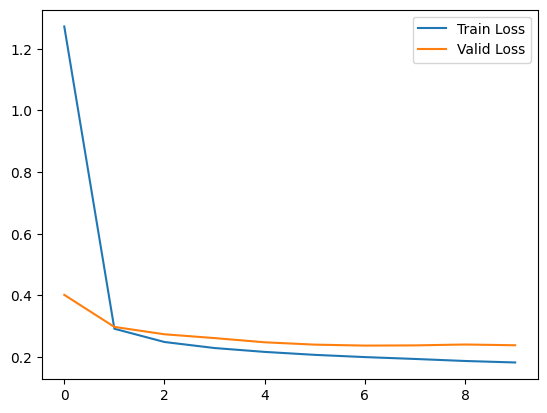

In [105]:
plt.plot(list_loss_train_fond.mean(axis = 1), label='Train Loss')
plt.plot(list_loss_valid_fond.mean(axis = 1), label='Valid Loss')
plt.legend()
plt.show()

In [106]:
def transformation_nutri_score_predictions(predictions):
    ind_min = predictions < 1.0
    ind_max = predictions > 5.0
    predictions[ind_min] = 1.0
    predictions[ind_max] = 5.0
    return predictions

In [107]:
model_fond.eval()
train_loss_off = ((transformation_nutri_score_predictions(model_fond(X_train_tensor_off).squeeze()) - y_train_tensor_off)**2).mean()
valid_loss_off = ((transformation_nutri_score_predictions(model_fond(X_valid_tensor_off).squeeze()) - y_valid_tensor_off)**2).mean()
test_loss_off  = ((transformation_nutri_score_predictions(model_fond(X_test_tensor_off).squeeze()) - y_test_tensor_off)**2).mean()
print(train_loss_off.item(), valid_loss_off.item(), test_loss_off.item())

0.2209298312664032 0.23100833594799042 0.23627696931362152


In [108]:
HSR_pred_FO = transformation_nutri_score_predictions(model_fond(X_test_tensor_off).squeeze()).detach().numpy()
error_pred_FO = np.round(((HSR_pred_FO - y_test_off)**2).mean(),3)
print(error_pred_FO)
star_pred_FO = np.round(HSR_pred_FO) 
acc_FO = np.abs(star_pred_FO - y_test_off) == 0
acc_by_one_FO = np.abs(star_pred_FO - y_test_off) <= 1
print(acc_FO.mean(), acc_by_one_FO.mean())

0.236
0.766412213740458 0.9862595419847329


### To-fine-tune model

In [85]:
batch_size = 32

model_head = Network(32, 
                activation_bool = False, 
                n_nodes = 32, 
                n_loop  = 0)

class ModelFT(nn.Module):
    def __init__(self):
        super(ModelFT, self).__init__()
        self.fondation_model = model_fond.seq[:-1]
        self.model_head = model_head
        
    def forward(self, x):
        x = self.fondation_model(x)
        x = self.model_head(x)
        return x
    
model_ft = ModelFT()

In [86]:
optimizer = schedulefree.AdamWScheduleFree(model_head.parameters(), #Only learning the last linear layer
                                           lr=0.01) #torch.optim.AdamW(model.parameters(), lr = 0.001)

net_path_ft = result_path + 'Fine-tuned-part.pt'

list_loss_train_ft, list_loss_valid_ft = training_network_threshold(model_ft, 
                           optimizer,
                           X_train    = X_train_tensor,
                           Y_train    = y_train_tensor,
                           X_test     = X_valid_tensor,
                           Y_test     = y_valid_tensor,
                           epochs     = 10,
                           batch_size = batch_size,
                           )

torch.save(model_ft.state_dict(), net_path_ft)

'''
model.load_state_dict(torch.load(net_path_ft, weights_only=True))
model.eval()
'''

'\nmodel.load_state_dict(torch.load(net_path_ft, weights_only=True))\nmodel.eval()\n'

In [87]:
list_loss_train_ft.mean(axis = 1)[-3:], list_loss_valid_ft.mean(axis = 1)[-3:]

(array([0.88219528, 0.83139677, 0.76805805]),
 array([2.20087457, 2.14601564, 2.05700588]))

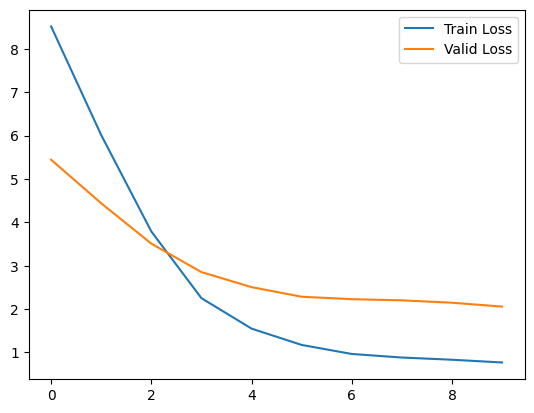

In [88]:
plt.plot(list_loss_train_ft.mean(axis = 1), label='Train Loss')
plt.plot(list_loss_valid_ft.mean(axis = 1), label='Valid Loss')
plt.legend()
plt.show()

In [90]:
model_ft.eval()
train_loss_ft = ((transformation_HSR_predictions(model_ft(X_train_tensor).squeeze()) - y_train_tensor)**2).mean()
valid_loss_ft = ((transformation_HSR_predictions(model_ft(X_valid_tensor).squeeze()) - y_valid_tensor)**2).mean()
test_loss_ft  = ((transformation_HSR_predictions(model_ft(X_test_tensor).squeeze()) - y_test_tensor)**2).mean()
print(train_loss_ft.item(), valid_loss_ft.item(), test_loss_ft.item())

0.7822945713996887 1.1512471437454224 0.8813742995262146


In [91]:
HSR_pred_FN = transformation_HSR_predictions(model_ft(X_test_tensor).squeeze()).detach().numpy()
error_pred_FN = np.round(((HSR_pred_FN - y_test)**2).mean(),3)
loss_dict['FN'] = error_pred_FN
print(error_pred_FN)
star_pred_FN = np.round(HSR_pred_FN * 2) / 2
acc_FN = np.abs(star_pred_FN - y_test) == 0
acc_by_one_FN = np.abs(star_pred_FN - y_test) <= 0.5
acc_dict['FN'] = acc_FN.mean()
acc_by_one_dict['FN'] = acc_by_one_FN.mean()
print(acc_FN.mean(), acc_by_one_FN.mean())

0.881
0.26 0.5


# Result Analysis

In [ ]:
dic_for_df = {}
model_name_list = ['LR', 'DTR', 'RFR', 'KNR', 'XGBR', 'SVR']
dic_for_df['Model'] = []
dic_for_df['MSE'] = []
dic_for_df['Acc'] = []
dic_for_df['Accuracy_by_one'] = []
for model_name in model_name_list:
    dic_for_df['Model'].append(model_name)
    dic_for_df['MSE'].append(loss_dict[model_name])
    dic_for_df['Acc'].append(acc_dict[model_name])
    dic_for_df['Accuracy_by_one'].append(acc_by_one_dict[model_name])
print(pd.DataFrame(dic_for_df).to_latex(index=False, float_format="{:.2f}".format))

# Labelling other datasets

## Pre-processing

In [77]:
df_openfoodfacts = pd.read_csv('Data/en.openfoodfacts.org.products.tsv', sep='\t',  low_memory=False)

In [80]:
df_off = df_openfoodfacts[['energy_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'categories']]
df_off.loc[:,'kcal'] = df_off.energy_100g / 4.184


C:\Users\Valentin\AppData\Local\Temp\ipykernel_28520\2978842777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off.loc[:,'kcal'] = df_off.energy_100g / 4.184


In [81]:
def apply_cat_dict(x):
    try:
        return dic_cat_off_to_cat_hsr[x]
    except:
        return float('nan')

In [82]:
df_off['category'] = df_off.categories.apply(apply_cat_dict)
df_off = df_off.drop('categories', axis = 1)

C:\Users\Valentin\AppData\Local\Temp\ipykernel_28520\2012702996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['category'] = df_off.categories.apply(apply_cat_dict)


In [89]:
df_off_clean = df_off[df_off.isna().sum(axis = 1) == 0]
len(df_off_clean)

6554

## Using our ML algorithm

In [84]:
df_off_clean_HSR_predictions = XGBR.predict(scaler.transform(pd.get_dummies(df_off_clean, ['category']).values))
df_off_clean['HSR_predictions'] = transformation_HSR_predictions(np.round(df_off_clean_HSR_predictions * 2) / 2 )

c:\Users\Valentin\Documents\Nutrition\hsr\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Valentin\AppData\Local\Temp\ipykernel_28520\2204453580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off_clean['HSR_predictions'] = transformation_HSR_predictions(np.round(df_off_clean_HSR_predictions * 2) / 2 )


In [90]:
df_off_clean_HSR_predictions = SVR.predict(scaler.transform(pd.get_dummies(df_off_clean, ['category']).values))
df_off_clean['HSR_predictions'] = transformation_HSR_predictions(np.round(df_off_clean_HSR_predictions * 2) / 2 )

c:\Users\Valentin\Documents\Nutrition\hsr\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Valentin\AppData\Local\Temp\ipykernel_28520\463496719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off_clean['HSR_predictions'] = transformation_HSR_predictions(np.round(df_off_clean_HSR_predictions * 2) / 2 )


C:\Users\Valentin\AppData\Local\Temp\ipykernel_28520\2736957396.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.histplot(data=df_off_clean.sort_values('category'), x='HSR_predictions', hue='category', multiple='stack', bins=9, palette=sns.color_palette("Set2", as_cmap=False))


<Axes: xlabel='HSR_predictions', ylabel='Count'>

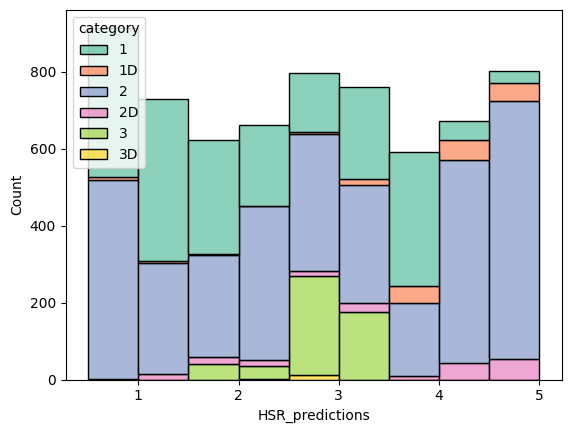

In [94]:
sns.histplot(data=df_off_clean.sort_values('category'), x='HSR_predictions', hue='category', multiple='stack', bins=9, palette=sns.color_palette("Set2", as_cmap=False))